In [483]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_2_open_solver_1.json")

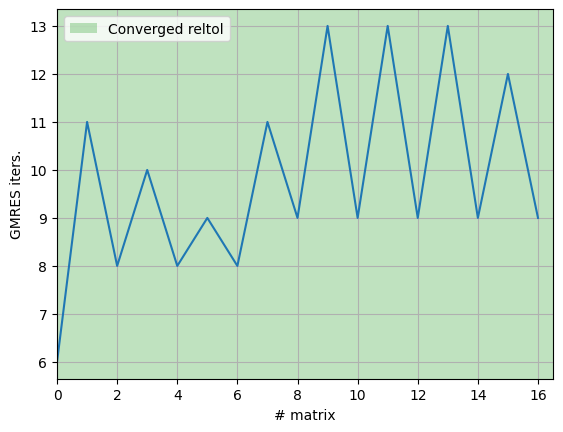

In [484]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [485]:
mat_idx = 14
# mat_idx = 8
get_gmres_iterations(data)[mat_idx]

9

In [486]:
sticking, sliding, open = get_num_sticking_sliding_open(data)
print(sticking[mat_idx], sliding[mat_idx], open[mat_idx])

8 0 160


In [487]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [488]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

Solve  took: 0.64


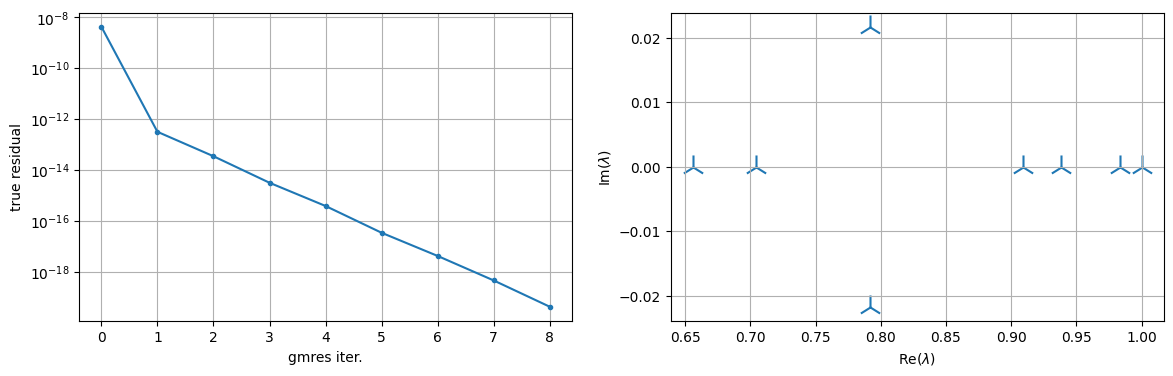

In [489]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

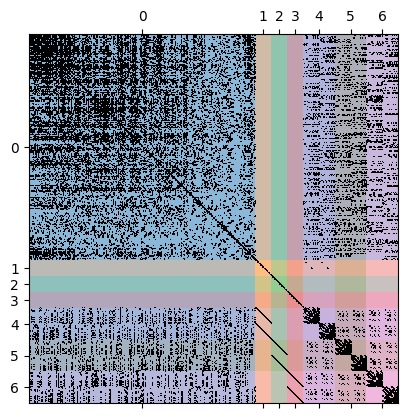

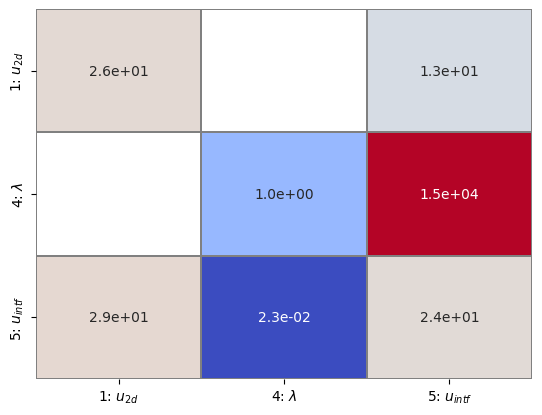

In [490]:
from block_matrix import BlockMatrixStorage
from pp_utils import correct_eq_groups

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

J = BlockMatrixStorage(
    mat=mat,
    row_idx=corrected_eq_dofs,
    col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)

J[[1, 4, 5]].color_spy(False)

# J[:].color_spy()
J[[1,4,5]].plot_max()
# J[:].matshow()

In [492]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization
from preconditioner_mech import build_mechanics_stabilization, make_local_fracture_dofs

In [493]:
mat_dofs, frac_dofs, intf_dofs = make_local_fracture_dofs(model)

J11_local = make_local_matrix(mat_dofs, mat_dofs).tocsr()

In [494]:
J15_local = make_local_matrix(intf_dofs, mat_dofs).tocsr()
J51_local = make_local_matrix(mat_dofs, intf_dofs).tocsr()
J55_local = make_local_matrix(intf_dofs, intf_dofs).tocsr()
J11_local = make_local_matrix(mat_dofs, mat_dofs).tocsr()

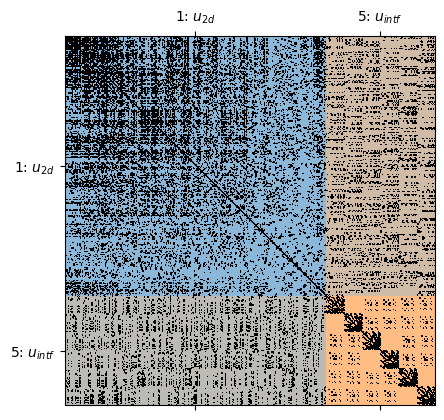

In [495]:
J15 = J[[1, 5]]
J15.color_spy()

Solve  took: 0.24


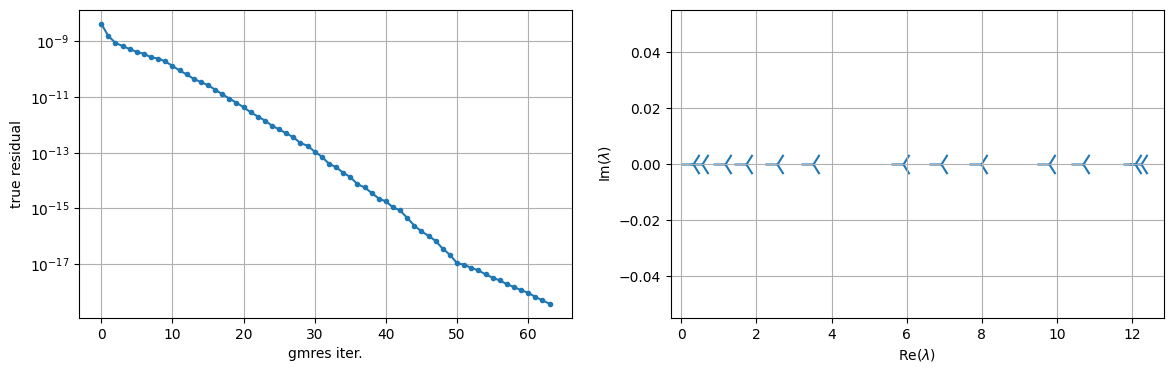

In [496]:
from block_matrix import SolveSchema, make_solver

schema1_amg = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    # invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),

    complement=schema1_amg,
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

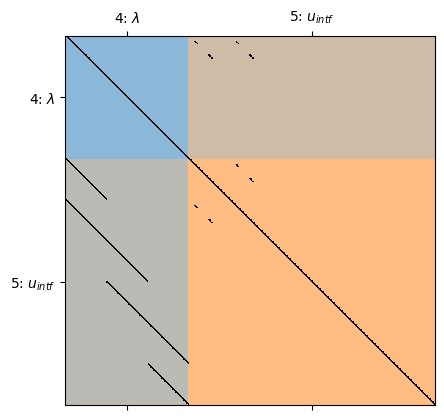

In [552]:
from preconditioner_mech import *

mat_dofs, frac_dofs, intf_dofs = make_local_fracture_dofs(model)

frac_dofs_unique = frac_dofs[::2]

J45 = J[[4,5]].copy()

# J45[[5]] = diag_nd(J45[[5]].mat, nd=model.nd)
J45[[5]] = lump_nd(J45[[5]].mat, nd=model.nd)

# # J11_local = take_local_values(J[1, 1].mat, mat_dofs, mat_dofs)
J44_local = take_local_values(J[4, 4].mat, frac_dofs, frac_dofs)
J45_local = take_local_values(J[4, 5].mat, frac_dofs, intf_dofs)
J54_local = take_local_values(J[5, 4].mat, intf_dofs, frac_dofs)
J55_local = take_local_values(J[5, 5].mat, intf_dofs, intf_dofs)

# J45.mat = inv(J45.mat)
J45.mat = build_mechanics_stabilization(model=model, bmat=J, build_schur=False, lump=True)

J45.color_spy()

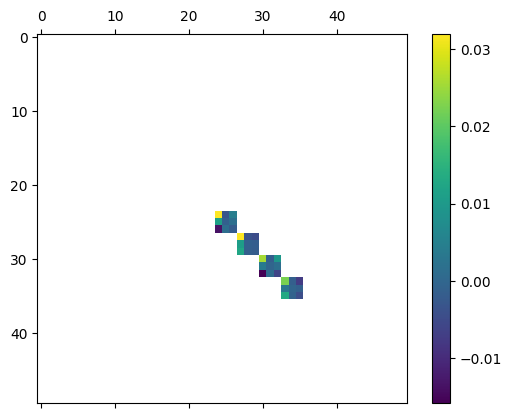

In [554]:
tmp = lump_nd(J45[[5]].mat, nd=model.nd) - diag_nd(J45[[5]].mat, nd=model.nd)
plot_mat(tmp[:50, :50], log=False)

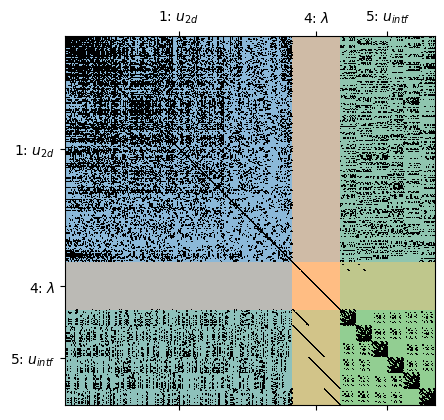

In [558]:
J[[1,4,5]].color_spy()

Solve  took: 0.09


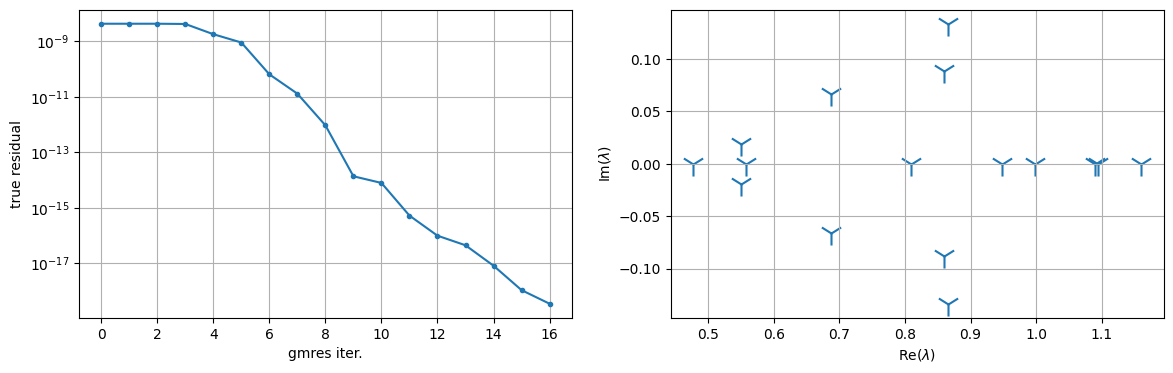

In [557]:
from block_matrix import SolveSchema, make_solver

schema15_amg = SolveSchema(
    groups=[1, 5],
    # groups=[5],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: J45[[4]].mat,
    # invertor=lambda bmat: J4_tilde,
    complement=schema15_amg,
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

In [500]:
from block_matrix import SolveSchema, make_solver

schema1_amg = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: J4_tilde,
    # invertor="use_solve",
    invertor=lambda bmat: scipy.sparse.csr_matrix(bmat.shape),
    complement=SolveSchema(
        groups=[5],
        solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
        invertor=lambda bmat: inv_block_diag(
            lump_nd(bmat.mat, nd=model.nd), nd=model.nd
        ),
        complement=schema1_amg
    ),
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

ValueError: dimension mismatch

In [501]:
from preconditioner_mech import *

mat_dofs, frac_dofs, intf_dofs = make_local_fracture_dofs(model)

frac_dofs_unique = frac_dofs[::2]

# # J11_local = take_local_values(J[1, 1].mat, mat_dofs, mat_dofs)
J44_local = take_local_values(J[4, 4].mat, frac_dofs, frac_dofs)
J45_local = take_local_values(J[4, 5].mat, frac_dofs, intf_dofs)
J54_local = take_local_values(J[5, 4].mat, intf_dofs, frac_dofs)
# J55_local = take_local_values(J[5, 5].mat, intf_dofs, intf_dofs)

J44_local = lump_rect(J[4, 4].mat, frac_dofs_unique, frac_dofs_unique)  # doesnt do anything
J45_local = lump_rect(J[4, 5].mat, frac_dofs, intf_dofs, axis=0)
J54_local = lump_rect(J[5, 4].mat, intf_dofs, frac_dofs, axis=1)
J55_local = lump_rect(J[5, 5].mat, intf_dofs, intf_dofs)
# J55_local = lump_nd(J[5, 5].mat, nd=model.nd)

# plot_mat(J54_local -, log=False)

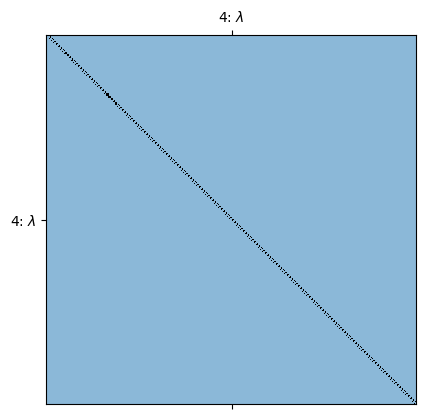

In [502]:
tmp = J[[4, 5]].copy()
tmp.mat = inv(bmat([
    [J44_local, J45_local],
    [J54_local, J55_local],
]))

# J15 = J[1, 5].mat
# J51 = J[5, 1].mat
tmp[4, 4].color_spy()
# tmp = tmp.mat

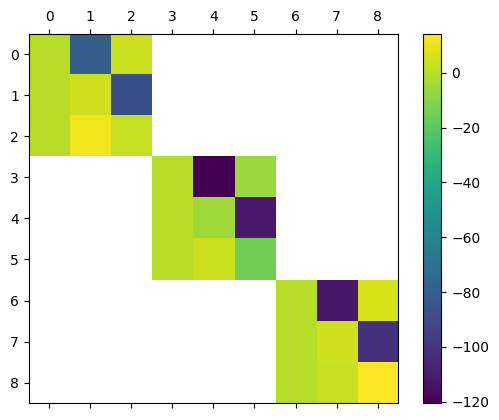

In [512]:
plot_mat(tmp[4, 4].mat[81:90, 81:90], log=False)

In [510]:
tmp[4, 4].mat[81:84, 81:84].A

array([[-2.91732840e-03, -8.00139199e+01,  3.72839833e+00],
       [-8.53376745e-04,  4.76843869e+00, -8.77343996e+01],
       [ 3.11840822e-02,  1.11945349e+01,  2.49760080e+00]])

In [478]:
(tmp[4, 4].mat[:2, :2]).A

array([[ 0.        ,  1.        ],
       [ 0.10572068, -0.00209825]])

Solve  took: 0.08


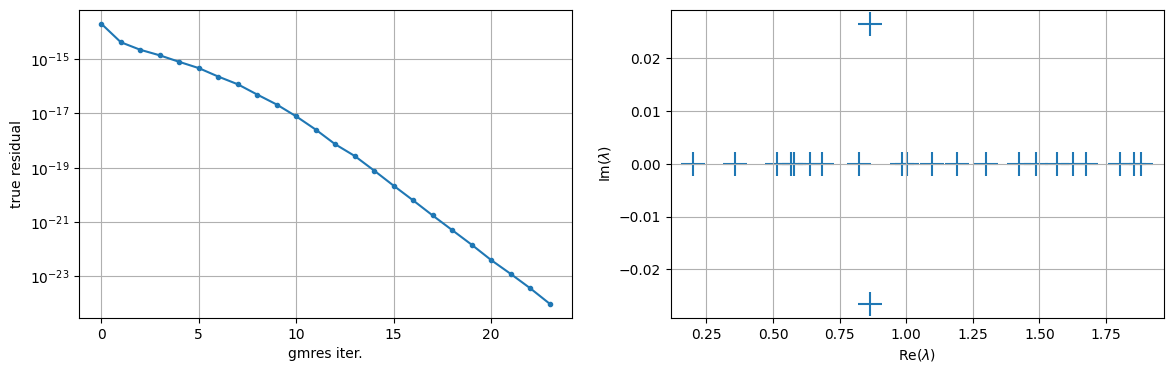

In [465]:
from block_matrix import SolveSchema, make_solver

schema1_amg = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: tmp,
    # solve=lambda bmat: build_mechanics_stabilization(model, J, build_schur=False, lump=True),
    invertor="use_solve",
    complement=schema1_amg,
)
mat_permuted, prec = make_solver(schema=schema, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))